<br/>

$$ \huge{\underline{\textbf{ Artificial Neural Network }}} $$

<br/>

<center>Example implementation of <b>Artificial Neural Network</b></center>
<center>from Sutton and Barto 2018, <b>chapter 9.7</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<a href="https://github.com/marcinbogdanski/ai_sketchpad"><- index</a>
    
<br/>

Even though explicit algorithm is not presented in the book, we will apply neural network to the corridor environment defined in [chapter 9.3](0903a_Gradient_MC.html)

We are going to use Gradient MC algorithm from chapter 9.3 as a learning algorithm. Before continuing you should familiarise yourself properly with [chapter 9.3](0903a_Gradient_MC.html).

Data generated by agent in reinforcement learning setting is highly correlated, observation at time step t=1000 is probably very similar to t=1001 and so on. Neural networks are inherently unstable when trained on highly correlated data.

As an introduction to this post read [this mini post](../Mini_Posts/ANN_Correlated_Data.html). It's very short and shows exactly why correlated data is bad and how memory reply fixes it.

I am going to present performance of vanilla gradient MC as well as modified version with memory reply.

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_ann.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure - difference between Gradient MC with and without memory reply on the corridor task.<center/></td>
    </tr>
</table>

---

# Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers_0905 import LinearEnv, plot_linear
from helpers_0907 import ANNFuncApprox

In [2]:
env = LinearEnv()

In [3]:
def policy(st):
    return np.random.choice([0, 1])

# Neural Network Function Approximator

ANNFuncApprox is a minimal implementation of ANN using only numpy. You can check the full source [here](helpers_0907.py)
* it has two layers only
  * sigmoid hidden layer
  * linear (no activation) output layer
  
Create neural net like so

In [4]:
model = ANNFuncApprox(learn_rate=1, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)

where **x_min** and **x_max** define input range (inputs are scaled internally to 0..1) and **nb_in**, **nb_hid** and **nb_out** are number of inputs, hidden units and outputs respectively. As you can see 3 hidden neurons is not really an earth shattering model, but then value function for corridor example is a stright line, so this should be plenty enough.

Usage is quite simple as well, you can feed in one data point at a time, or in batches

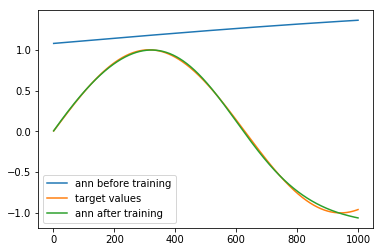

In [5]:
x = np.linspace(start=1, stop=1000, num=1000).reshape([-1,1])
y = np.sin(x/200)

plt.plot(x, model.eval(x), label='ann before training')
plt.plot(x, y, label='target values')

for i in range(10000):
    model.train(x, y)

plt.plot(x, model.eval(x), label='ann after training')
plt.legend();

# Vanilla Gradient MC + Neural Network

This is just a standard Gradient MC as presented in [chapter 9.3](0903a_Gradient_MC.html). We will use the "fixed" version of Gradient MC, repeated here for reference.

In [6]:
def gradient_MC_vanilla(env, policy, ep, gamma, model, callback=None, trace=None):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env    - environment
        policy - function in a form: policy(state)->action
        ep     - number of episodes to run
        gamma  - discount factor [0..1]
        model  - function approximator, already initialised, with method:
                     train(state, target) -> None
        callback - function in a form: callback(episode, model, trace) -> None
        trace  - passed to callback, so it can log data into it
    """
    for e_ in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
            model.train(St, Gt)
               
        if callback is not None:
            callback(e_, model, trace)

Helper functions:

In [7]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

### Quick test

Let's try to train just like we did with polynomial basis or tile coding.

Neural net before training:

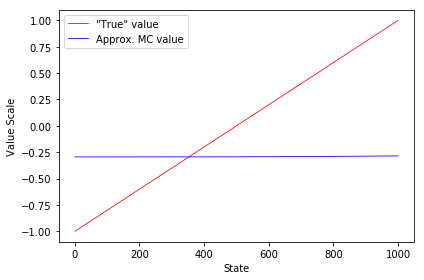

In [8]:
model = ANNFuncApprox(learn_rate=0.01, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
V = [float(model.eval(st)) for st in range(1001)]
plot_linear(V, env=env)

Train for 1000 episodes

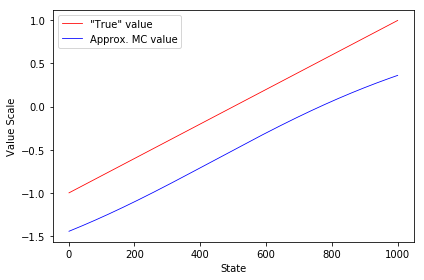

In [9]:
gradient_MC_vanilla(env, policy, ep=1000, gamma=1.0, model=model)
V = [float(model.eval(st)) for st in range(1001)]
plot_linear(V, env=env)

and another 1000 episodes

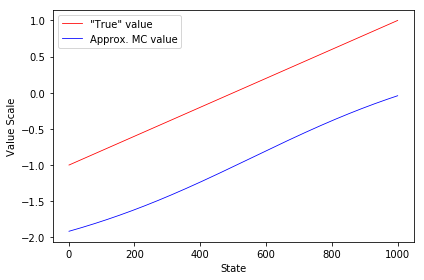

In [10]:
gradient_MC_vanilla(env, policy, ep=1000, gamma=1.0, model=model)
V = [float(model.eval(st)) for st in range(1001)]
plot_linear(V, env=env)

This is clearly not working. Let's generate some episodes and have a look at the raw data that is being feed into neural network

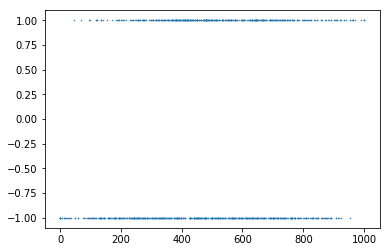

In [11]:
xx, yy = [], []
for ep in range(10):
    traj, T = generate_episode(env, policy)
    for i in range(len(traj)):
        xx.append(traj[i][0])
        yy.append(traj[-1][1])
    
plt.scatter(xx, yy, marker='.', s=1);

No wonder neural network has trouble fitting that. We could try with much lower learning rate and much longer training.

Reset and train new neural network. This may take couple minutes

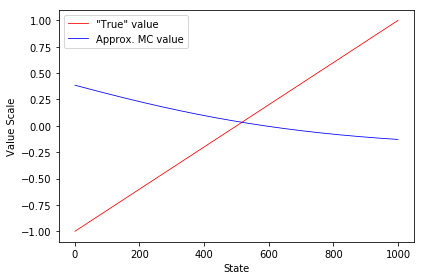

In [12]:
model = ANNFuncApprox(learn_rate=0.00001, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
gradient_MC_vanilla(env, policy, ep=5000, gamma=1.0, model=model)
V = [float(model.eval(st)) for st in range(1001)]
plot_linear(V, env=env)

Nope, still doesn't work, it just fits line between extreemes -1 and 1, let's see if we can fix this with memory reply.

# Gradient MC + Neural Network + Memory Reply

In [13]:
def gradient_MC_memrep(env, policy, ep, gamma, model, callback=None, trace=None):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env    - environment
        policy - function in a form: policy(state)->action
        ep     - number of episodes to run
        gamma  - discount factor [0..1]
        model  - function approximator, already initialised, with method:
                     train(state, target) -> None
        callback - function in a form: callback(episode, model, trace) -> None
        trace  - passed to callback, so it can log data into it
    """
    
    mem_states = CircularBuff(maxlen=100000, dtype=int)           # <- circular buffer with
    mem_returns = CircularBuff(maxlen=100000, dtype=float)        #    history of visited states
    
    for e_ in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
            
            mem_states.append(St)                                 # <- instead of training
            mem_returns.append(Gt)                                #    save to memory
        
        
        idx = np.random.randint(low=0, high=len(mem_states),      # <- after each episode
                                size=min(10000,len(mem_states)))  #    sample from memory and
        states = mem_states.data[idx].reshape([-1,1])             #    construct column vectors
        returns = mem_returns.data[idx].reshape([-1,1])           #    for batch learning
        model.train(states, returns)                              # <- and batch train neural net
               
        if callback is not None:
            callback(e_, model, trace)

Helper class:

In [14]:
class CircularBuff:
    def __init__(self, maxlen, dtype):
        self.maxlen = maxlen
        self.idx = 0
        self.length = 0
        self.data = np.zeros(shape=[maxlen], dtype=dtype)
    
    def append(self, item):
        self.data[self.idx] = item
        self.idx += 1
        if self.idx >= len(self.data):
            self.idx = 0
            
        if self.length < self.maxlen:
            self.length += 1
            
    def __len__(self):
        return self.length

Technically we could use collections.deque, buth deque is slow for index access.

### Quick test

Note higher learning rate is now possible, also training only on 1k episodes.

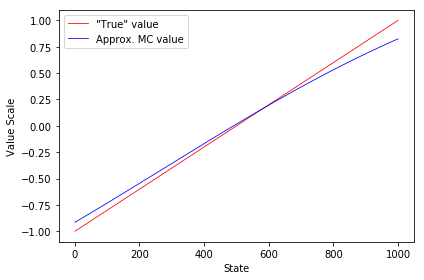

In [15]:
model = ANNFuncApprox(learn_rate=0.2, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
gradient_MC_memrep(env, policy, ep=1000, gamma=1.0, model=model)
V = [float(model.eval(st)) for st in range(1001)]
plot_linear(V, env=env)

That looks better

# Hyperparameter search

Through this post I was kind of pulling hyperparemeters out of a hat. In actually I spent quite a bit of time finding them. Here is a quick param search to convince ourselves that memory reply really works, and it's not just different hyperparameters.

Define callback to track results during training

In [16]:
def callback(episode, model, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    if episode % 100 != 0:    return
    V = np.array([float(model.eval(st)) for st in range(1001)])                # arr of float
    err = np.sqrt(np.mean(np.power((np.array(V[1:]) - env.V_approx[1:]), 2)))  # float
    trace.append(err)

Generate data for Vanilla MC

In [18]:
trace_vanilla_lr_0_001 = []
model = ANNFuncApprox(learn_rate=0.001, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
gradient_MC_vanilla(env, policy, ep=5000, gamma=1.0,
                    model=model, callback=callback, trace=trace_vanilla_lr_0_001)

In [19]:
trace_vanilla_lr_0_0001 = []
model = ANNFuncApprox(learn_rate=0.0001, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
gradient_MC_vanilla(env, policy, ep=5000, gamma=1.0,
                    model=model, callback=callback, trace=trace_vanilla_lr_0_0001)

In [20]:
trace_vanilla_lr_0_00001 = []
model = ANNFuncApprox(learn_rate=0.00001, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
gradient_MC_vanilla(env, policy, ep=5000, gamma=1.0,
                    model=model, callback=callback, trace=trace_vanilla_lr_0_00001)

And for Memory Reply MC

In [21]:
trace_memrep_lr_0_1=[]
model = ANNFuncApprox(learn_rate=0.1, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
gradient_MC_memrep(env, policy, ep=5000, gamma=1.0,
                   model=model, callback=callback, trace=trace_memrep_lr_0_1)

In [22]:
trace_memrep_lr_0_033=[]
model = ANNFuncApprox(learn_rate=0.033, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
gradient_MC_memrep(env, policy, ep=5000, gamma=1.0,
                   model=model, callback=callback, trace=trace_memrep_lr_0_033)

In [23]:
trace_memrep_lr_0_01=[]
model = ANNFuncApprox(learn_rate=0.1, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
gradient_MC_memrep(env, policy, ep=5000, gamma=1.0,
                   model=model, callback=callback, trace=trace_memrep_lr_0_01)

Plot the results

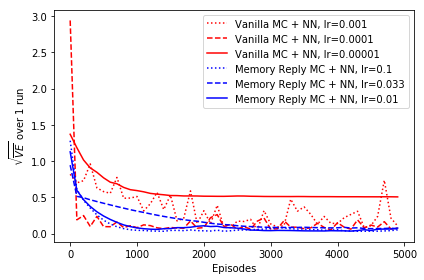

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
xx_temp = np.array(range(len(trace_vanilla_lr_0_01))) * 100

ax.plot(xx_temp, trace_vanilla_lr_0_001, 
        color='red', linestyle=':', label='Vanilla MC + NN, lr=0.001')
ax.plot(xx_temp, trace_vanilla_lr_0_0001, 
        color='red', linestyle='--', label='Vanilla MC + NN, lr=0.0001')
ax.plot(xx_temp, trace_vanilla_lr_0_00001, 
        color='red', linestyle='-', label='Vanilla MC + NN, lr=0.00001')

ax.plot(xx_temp, trace_memrep_lr_0_1, 
        color='blue', linestyle=':', label='Memory Reply MC + NN, lr=0.1')
ax.plot(xx_temp, trace_memrep_lr_0_033, 
        color='blue', linestyle='--', label='Memory Reply MC + NN, lr=0.033')
ax.plot(xx_temp, trace_memrep_lr_0_01, 
        color='blue', linestyle='-', label='Memory Reply MC + NN, lr=0.01')

ax.set_ylabel('$\sqrt{\overline{VE}}$ over 1 run')
ax.set_xlabel('Episodes')
ax.legend()
plt.tight_layout()
# plt.savefig('assets/fig_ann.png')
plt.show()